In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils import data as wrapper
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import tqdm
import os

In [3]:
class MNIST10Linear(nn.Module):
      def __init__(self):
          super( MNIST10Linear, self).__init__()
          self.fc1 = nn.Linear(14*14, 64) ## <-----   Diminui os neurinios de entreda para acomodar a imagem comprimida
          self.fc2 = nn.Linear(64, 64)
          self.fc3 = nn.Linear(64, 64)
          self.fc4 = nn.Linear(64, 10)

      def forward(self, x):
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = F.relu(self.fc3(x))
          x = self.fc4(x)
          return F.log_softmax(x, dim=1)

In [4]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 0))

In [5]:
#compression_transformation = transforms.Lambda(lambda x: hensel_compression(x))
compression_transformation = transforms.Lambda(lambda x: x)

mnistTransformation = transforms.Compose(
          [transforms.ToTensor(), compression_transformation])




train = datasets.MNIST("",
                      train = True,
                      download = True,
                      transform = mnistTransformation)
test = datasets.MNIST("",
                      train = False,
                      download = False,
                      transform = mnistTransformation)

trainset = wrapper.DataLoader(train, batch_size=30, shuffle=False)
testset = wrapper.DataLoader(test, batch_size=30, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 90040804.61it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50452184.02it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38832815.24it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6566883.41it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [6]:
_epoch_count = []
loss_values = []
test_loss_values = []

epochs = 5
torch.random.manual_seed(70)
net = MNIST10Linear()
optimizer = optim.Adam(net.parameters(), lr=0.01)

device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

MNIST10Linear(
  (fc1): Linear(in_features=196, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)



_global loss

for epoch in range(epochs):
  for batch, dset in enumerate(trainset):
    X, y = dset
    X = X.to(device)
    y = y.to(device)
    net.train()
    output = net(X.view(-1,28*28))
    loss = F.nll_loss(output, y)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    #print(f"epoch: {epoch}, loss: {loss}")

  with torch.inference_mode(): # turns off grafient tracking
    for batch, test_dset in enumerate(testset):
      X_test, y_test = test_dset
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      # Do the forward pass
      test_pred = net(X_test.view(-1,28*28))

      # Calculate the loss
      test_loss = F.nll_loss(test_pred, y_test)

  # Print out whatss happening
  if True :
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

#dy_dx = torch.autograd.grad(loss, net.parameters())
#original_dy_dx = list((_.clone() for _ in dy_dx))

In [7]:
def tensor_to_PIL(img):
  tt = transforms.ToPILImage()
  PIL_image = tt(img.cpu())
  return PIL_image

In [8]:
def batch_to_PIL(X):
  out = map(tensor_to_PIL, X)
  return list(out)

In [9]:
def run_once(f):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.has_run = True
            return f(*args, **kwargs)
    wrapper.has_run = False
    return wrapper

In [10]:
@run_once
def show_image_compressed(img):
  plt.imshow(img)
  plt.title("Reconstructed image")

In [11]:
@run_once
def show_image_original(img):
  plt.imshow(img)
  plt.title("Original image")

In [12]:
def show_image(img):
  plt.imshow(img)
  plt.title("Image")
  #print("Onehot label is %d." % torch.argmax(dummy_label, dim=-1))

In [13]:
def hensel_compression(image_to_compress) -> torch.Tensor:
  dimension = image_to_compress.shape[-1]
  parser_x = 0
  parser_y = 0
  compressed_row = []
  compressed_image_list = []
  show_image_original(image_to_compress)
  while parser_y+2<=dimension:
    while parser_x+2<=dimension:
      cell = image_to_compress[..., parser_y:parser_y+2, parser_x:parser_x+2]
      compression = 0
      for enum, elem in enumerate(cell.flatten().tolist()):
        compression += elem*(0.001**enum)
      compressed_row.append(compression)
      parser_x = parser_x+2
    compressed_image_list.append(torch.tensor(compressed_row))
    compressed_row=[]
    show_image_compressed(tensor_to_PIL(torch.stack(compressed_image_list)))
    parser_y = parser_y+2
    parser_x = 0
  compressed_image = torch.stack(compressed_image_list)
  compressed_image_unsqueezed = torch.unsqueeze(compressed_image, dim=0)
  return compressed_image_unsqueezed



In [14]:
#def hensel_compression(image_to_compress) -> torch.Tensor:
#  dimension = image_to_compress.shape[-1]
#  parser_x = 0
#  parser_y = 0
#  compressed_row = []
#  compressed_image_list = []
#  show_image_original(image_to_compress)
#  while parser_y+2<=dimension:
#    while parser_x+2<=dimension:
#      cell = image_to_compress[..., parser_x:parser_x+2, parser_y:parser_y+2]
#      compression = 0
#      for enum, elem in enumerate(cell.flatten().tolist()):
#        compression += elem*(3**enum)
#      compressed_row.append(compression)
#      parser_x = parser_x+2
#    compressed_image_list.append(torch.tensor(compressed_row))
#    compressed_row=[]
#    show_image_compressed(tensor_to_PIL(torch.stack(compressed_image_list)))
#    parser_y = parser_y+2
#    parser_x = 0
#  compressed_image = torch.stack(compressed_image_list)
#  compressed_image_unsqueezed = torch.unsqueeze(compressed_image, dim=0)
#  return compressed_image_unsqueezed

In [15]:
def compress_batch(batch):
  batch = batch.cpu()
  return torch.stack(list(map(hensel_compression, batch.squeeze()))).to(device)

torch.Size([28, 28])

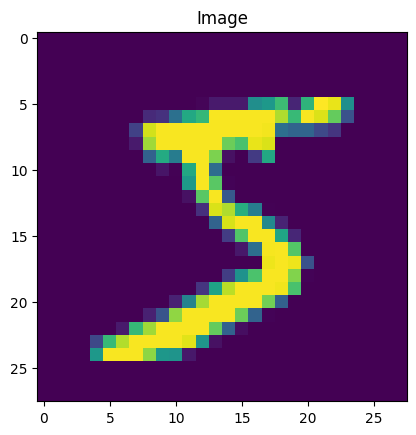

In [16]:
X = next(iter(trainset))
#print(X) #-> zip(image_batch, label_batch)
#compress_batch = lambda x: hensel_compression(x)


show_image(X[0][0].squeeze())
X[0][0].squeeze().shape

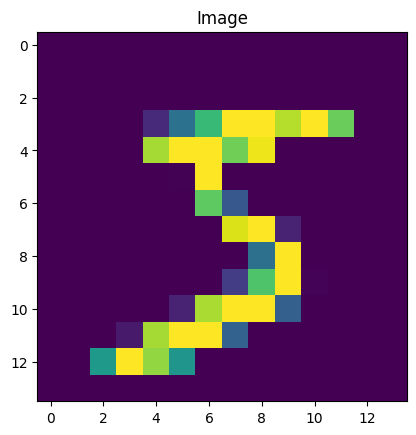

In [17]:
image_to_compress = X[0][0].squeeze()
compressed = hensel_compression(image_to_compress)
show_image(compressed[0])

In [18]:
compressed[0].shape

torch.Size([14, 14])

In [21]:
def train_metric_network():
  global loss
  optimizer_metric = optim.Adam(net_metric.parameters(), lr=0.01)
  device = "cuda" if torch.cuda.is_available() else "cpu"
  net_metric.to(device)

  for epoch in range(epochs):
    for batch, dset in enumerate(trainset):
      X, y = dset
      X = X.to(device)
      print("printing x size")
      print(X.shape)
      y = y.to(device)
      net_metric.train()
      X = compress_batch(X)
      print("X compressed_shape", X.shape)
      show_image(batch_to_PIL(X)[0])
      # output = net_metric(torch.stack(list(map(compressed_batch, X))).to(device).view(-1,14*14))
      output = net_metric(X.view(-1,14*14))
      print("output_size", output.shape)
      print("y_size", y.shape)
      loss = F.nll_loss(output, y)
      optimizer_metric.zero_grad()
      loss.backward(retain_graph=True)
      optimizer_metric.step()
      #print(f"epoch: {epoch}, loss: {loss}")

    with torch.inference_mode(): # turns off grafient tracking
      for batch, test_dset in enumerate(testset):
        X_test, y_test = test_dset
        X_test = compress_batch(X_test)
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        # Do the forward pass
        # test_pred = net_metric(torch.stack(list(map(compressed_batch, X_test))).to(device).view(-1,14*14))
        test_pred = net_metric(X_test.view(-1,14*14))

        # Calculate the loss
        test_loss = F.nll_loss(test_pred, y_test)

    # Print out whatss happening
    if True :
      #epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

  #dy_dx = torch.autograd.grad(loss, net.parameters())
  #original_dy_dx = list((_.clone() for _ in dy_dx))

In [23]:
net_metric_path = 'your_model.pth'
if os.path.isfile(net_metric_path):
    # Load the saved model
    net_metric = MNIST10Linear()
    net_metric.load_state_dict(torch.load(net_metric_path))
    net_metric.eval()  # Put the model in evaluation mode if needed
    print("Loaded model from", net_metric_path)
else:
    # If the saved model doesn't exist, call the training procedure
    print("No saved model found. Training a new model...")
    net_metric = MNIST10Linear()
    model = train_metric_network()
    # Call your training procedure here
    # For example:
    # train_model(model)
    # After training, save the model
    torch.save(net_metric.state_dict(), net_metric_path)
    print("Model saved at", net_metric_path)


Loaded model from your_model.pth


In [24]:
def image_classification_error(nn, original_PIL, reconstructed_PIL):
  with torch.inference_mode():
    out1 = nn(original_PIL.view(-1,28*28))
    out2 = nn(reconstructed_PIL.view(-1,28*28))
  return torch.sum(abs(out1 - out2)).item()

In [ ]:
#def image_error(original_image, inversion_image):
#  return abs(torch.sum(original_image[0].cpu() - inversion_image[0].cpu()).item())

In [25]:
def show_privacy_evolution(privacy_leak_evolution):
  x = np.arange(1, len(privacy_leak_evolution)+1)
  default_x_ticks = range(len(x))
  plt.plot(default_x_ticks, privacy_leak_evolution)
  plt.xticks(default_x_ticks, x)
  plt.xlabel("Samples per batch")
  plt.ylabel("Inversion error")
  plt.show()

In [26]:
X.shape

AttributeError: ignored

In [29]:

def inversion():
    global inversion_loss
    global original_dy_dx
    global reconstructed_images
    global privacy_leak_evolution

    tt = transforms.ToPILImage()
    net.train()
    image, label = next(iter(trainset))
    image, label = image.to(device), label.to(device)
    a = image.cpu()
    plt.imshow(tt(a[0]))
    inversion_outputs = net(image.to(device).view(-1,28*28))
    label = F.one_hot(label, num_classes=10)
    inversion_loss = cross_entropy_for_onehot(inversion_outputs.squeeze(), label.to(device))

    dy_dx = torch.autograd.grad(inversion_loss, net.parameters())
    # share the gradients with other clients
    original_dy_dx = list((_.detach().clone() for _ in dy_dx))

    torch.random.manual_seed(490)
    dummy_data = torch.randn(image.size()).to(device)
    torch.random.manual_seed(490)
    dummy_label = torch.randn(label.size()).to(device)
    dummy_data = dummy_data.to(device).requires_grad_(True)
    dummy_label = dummy_label.to(device).requires_grad_(True)
    #target = image[0].cpu()
    #tt = transforms.ToPILImage()
    #plt.imshow(tt(target))
    #plt.title("Ground truth image")
    #print("Onehot label is %d." % torch.argmax(label[0], dim=-1))
    optimizer_inversion = torch.optim.LBFGS([dummy_data, dummy_label], lr=1, max_iter=20)
    criterion = cross_entropy_for_onehot
    history = []
    losses = []
    not_convergence = True
    iters = 0
    #for iters in range(300):
    while not_convergence:
        #print(dummy_data[-1, -1,])
        def closure():
            optimizer_inversion.zero_grad()

            pred = net(dummy_data.view(-1,14*14))
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
            grad_diff.backward()
            losses.append(grad_diff)
            return grad_diff

        optimizer_inversion.step(closure)
        if iters % 10 == 0 and iters != 0:
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())
            #losses.append(current_loss)
            if(losses[iters] - losses[iters - 10] <= 0.001 and iters >= 100): # and iters >= 100
              not_convergence = False
        history.append(dummy_data[0].cpu())
        iters = iters+1
    print(dummy_data.size())
    tt = transforms.ToPILImage()
    reconstructed_images.append(tt(dummy_data[0].cpu()))

    privacy_indicator = image_classification_error(net_metric, image, dummy_data)
    privacy_leak_evolution.append(privacy_indicator)
    #print("Onehot label is %d." % torch.argmax(dummy_label, dim=-1))

RuntimeError: ignored

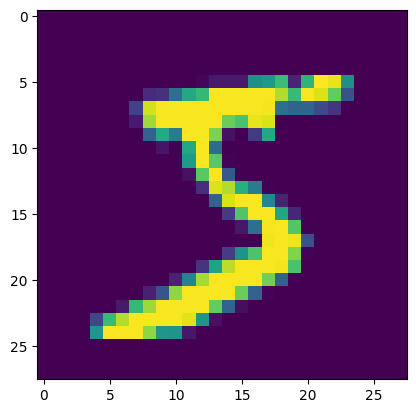

In [30]:
inversion()
print(original_dy_dx)

In [ ]:
def show_original_image():
  tt = transforms.ToPILImage()
  plt.imshow(tt(image[0].cpu()))
  plt.title("Reconstructed image")
  #print("Onehot label is %d." % torch.argmax(dummy_label, dim=-1))

In [ ]:
reconstructed_images = []
privacy_leak_evolution = []
for i in range(1, 15):
  trainset = wrapper.DataLoader(train, batch_size= i, shuffle=False)
  testset = wrapper.DataLoader(test, batch_size= i, shuffle=False)
  inversion()



In [ ]:
plt.imshow(reconstructed_images[13])
plt.title("Reconstructed image")
#print("Onehot label is %d." % torch.argmax(dummy_label, dim=-1))

In [ ]:
for i, elem in enumerate(reconstructed_images):
  elem.save('images_per_batch_size_exp_#' + str(i) + ".png")

In [ ]:
privacy_leak_evolution = [0.0807027816772461,
 236.84188842773438,
 283.19647216796875,
 623.4032592773438,
 750.733642578125,
 849.158203125,
 1037.207763671875,
 1512.766845703125,
 1785.4864501953125,
 2585.1201171875,
 3018.494873046875,
 3099.3759765625,
 4234.27880859375,
 4146.06689453125]
show_privacy_evolution(privacy_leak_evolution)

In [ ]:
privacy_leak_evolution